# Youtube Video Tags Analysis

## Step 1: Get all data on the keyword specified from the API

In [1]:
from googleapiclient.discovery import build
import pandas as pd
import re
import sqlite3
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# xlsxwriter

In [2]:
API_KEY = ""
youtube = build("youtube", "v3", developerKey=API_KEY)

In [2]:
KEYWORD = "python"

In [4]:
snippets = youtube.search().list(part="snippet", q=KEYWORD).execute()

In [5]:
for item in snippets:
    print(item)

kind
etag
nextPageToken
regionCode
pageInfo
items


In [6]:
snippets["items"][0]["id"]["videoId"]

'gfDE2a7MKjA'

In [7]:
allVideoId = []
nextPage_token = None
ind = 0
while 1:
    res = (
        youtube.search()
        .list(part="snippet", q=KEYWORD, maxResults=50, pageToken=nextPage_token)
        .execute()
    )

    for i in range(len(res["items"])):
        # print(i)
        try:
            # print(res['items'][i]['id']['videoId'])
            allVideoId.append(res["items"][i]["id"]["videoId"])
        except Exception as e:
            pass
            # print(e)

    nextPage_token = res.get("nextPageToken")

    if nextPage_token is None:
        break
    # print(ind)


In [8]:
len(allVideoId)

644

In [9]:
allVideoData = []
for i in allVideoId:
    video = (
        youtube.videos().list(part="snippet,statistics,contentDetails", id=i).execute()
    )
    # print(video['items'][0]['snippet']['tags'])
    try:
        allVideoData.append(video["items"][0])
    except:
        pass


In [10]:
len(allVideoData)

644

## Step 2: Clean & Store the data in a DB
The reason I have chosen a DB is that it is easier to handle data.

I was thinking of going towards a file, but I chose DB as we can cater the many-to-many relationship between video&tag by making a new table

Storing information in a db gives us a clear idea of the structure and also makes the analysis of data easier

In [11]:
print("Tags", "========>", allVideoData[1]["snippet"]["tags"])

Tags ========> ['python tutorial', 'python', 'python for beginners', 'python tutorial for beginners', 'learn python', 'python crash course', 'python 2019', 'python tutorial for beginners full', 'python (programming language)', 'python basics', 'python course', 'python from scratch', 'python full course', 'python language', 'python programming', 'python programming language', 'python programming tutorial', 'getting started with python', 'learn python programming', 'web development', 'mosh hamedani', 'machine learning', 'python 2020']


### We got all the tags needed, now we will clean the data, we will convert each tag lower case so that we don't mishandle the data

In [12]:
for i in range(len(allVideoData)):
    try:
        allVideoData[i]["snippet"]["tags"] = [
            tag.lower().strip() for tag in allVideoData[i]["snippet"]["tags"]
        ]
    except:
        pass


In [13]:
print("Tags", "========>", allVideoData[1]["snippet"]["tags"])

Tags ========> ['python tutorial', 'python', 'python for beginners', 'python tutorial for beginners', 'learn python', 'python crash course', 'python 2019', 'python tutorial for beginners full', 'python (programming language)', 'python basics', 'python course', 'python from scratch', 'python full course', 'python language', 'python programming', 'python programming language', 'python programming tutorial', 'getting started with python', 'learn python programming', 'web development', 'mosh hamedani', 'machine learning', 'python 2020']


### Converting the json data into a DB

In [14]:
for i in allVideoData[0]:
    print(i)

kind
etag
id
snippet
contentDetails
statistics


In [15]:
def YTDurationToSeconds(duration):
    match = re.match("PT(\d+H)?(\d+M)?(\d+S)?", duration).groups()
    hours = _js_parseInt(match[0]) if match[0] else 0
    minutes = _js_parseInt(match[1]) if match[1] else 0
    seconds = _js_parseInt(match[2]) if match[2] else 0
    return hours * 3600 + minutes * 60 + seconds


def _js_parseInt(string):
    return int("".join([x for x in string if x.isdigit()]))


# Creating Database

In [19]:
connection = sqlite3.connect('storage.db')
cursor = connection.cursor()

In [20]:
cursor.execute(
    """CREATE TABLE video
    (
      video_id VARCHAR(50) NOT NULL,
      published DATE NOT NULL,
      views INT NOT NULL,
      likes INT NOT NULL,
      comments INT NOT NULL,
      duration INT NOT NULL,
      channel_id VARCHAR(50) NOT NULL,
      title VARCHAR(255) NOT NULL,
      description VARCHAR(500) NOT NULL,
      channel_title VARCHAR(255) NOT NULL,
      category_id INT NOT NULL,
      PRIMARY KEY (video_id)
    );"""
)


cursor.execute(
    """CREATE TABLE category
    (
      category_id INT NOT NULL,
      category_name VARCHAR(255) NOT NULL,
      PRIMARY KEY (category_id)
    );"""
)

cursor.execute(
    """CREATE TABLE tag
    (
      video_tag_id  INTEGER PRIMARY KEY  AUTOINCREMENT,
      video_id VARCHAR(50) NOT NULL,
      tag_name VARCHAR(255) NOT NULL
    );"""
)


In [21]:
connection.commit()

## Inserting Categories

In [22]:
category = [
2 , "Autos & Vehicles",
1 ,  "Film & Animation",
10 , "Music",
15 , "Pets & Animals",
17 , "Sports",
18 , "Short Movies",
19 , "Travel & Events",
20 , "Gaming",
21 , "Videoblogging",
22 , "People & Blogs",
23 , "Comedy",
24 , "Entertainment",
25 , "News & Politics",
26 , "Howto & Style",
27 , "Education",
28 , "Science & Technology",
29 , "Nonprofits & Activism",
30 , "Movies",
31 , "Anime/Animation",
32 , "Action/Adventure",
33 , "Classics",
34 , "Comedy",
35 , "Documentary",
36 , "Drama",
37 , "Family",
38 , "Foreign",
39 , "Horror",
40 , "Sci-Fi/Fantasy",
41 , "Thriller",
42 , "Shorts",
43 , "Shows",
44 , "Trailers"]
category_id = []
category_name = []
for i in range(len(category)):
    if i%2==0:
        category_id.append(category[i])
    else:
        category_name.append(category[i])


In [23]:
for i in range(len(category_id)):
    cursor.execute(
    """
        INSERT INTO category (category_id, category_name) 
                                VALUES (?, ?);
    """,
        (category_id[i], category_name[i]),
    )

connection.commit()


## Inserting video

In [24]:
for i in range(len(allVideoData)):
    video_id = allVideoData[i]["id"]
    publishedAt = datetime.fromisoformat(
        allVideoData[i]["snippet"]["publishedAt"].replace("T", " ").replace("Z", "")
    )
    channelId = allVideoData[i]["snippet"]["channelId"]
    title = allVideoData[i]["snippet"]["title"]
    description = allVideoData[i]["snippet"]["description"]
    channelTitle = allVideoData[i]["snippet"]["channelTitle"]
    categoryId = allVideoData[i]["snippet"]["categoryId"]
    viewCount = allVideoData[i]["statistics"]["viewCount"]
    try:
        likeCount = allVideoData[i]["statistics"]["likeCount"]
    except:
        likeCount = 0
    try:
        commentCount = allVideoData[i]["statistics"]["commentCount"]
    except:
        commentCount = 0
    try:
        duration = YTDurationToSeconds(allVideoData[i]["contentDetails"]["duration"])
    except:
        duration = 0

    try:
        cursor.execute(
        """
            INSERT INTO video (video_id, published, views, likes, comments, duration, channel_id, title, description,
                            channel_title, category_id) 
                                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
        """,
            (
                video_id,
                publishedAt,
                viewCount,
                likeCount,
                commentCount,
                duration,
                channelId,
                title,
                description,
                channelTitle,
                categoryId,
            ),
        )
    except:
        pass
connection.commit()


## Inserting tag

In [25]:
TAGS = []
for i in range(len(allVideoData)):
    try:
        TAGS.append((allVideoData[i]["id"], allVideoData[i]["snippet"]["tags"]))
    except:
        pass


for i in TAGS:
    for j in i[1]:
        # print(i[0], j)
        cursor.execute(
            """
            INSERT INTO tag (video_id, tag_name) 
                                        VALUES (?, ?);
            """,
            (i[0], j),
        )


In [26]:
connection.commit()
connection.close()

# Step 3: Analysis

In [4]:
conn = sqlite3.connect("storage.db")

sql_query = pd.read_sql_query(
    """
        SELECT *
        FROM tag t
        LEFT JOIN video v
        ON t.video_id = v.video_id
        LEFT JOIN category c 
        on v.category_id = c.category_id 
    """,
    conn,
)
conn.close()
df = pd.DataFrame(sql_query)

df = df.loc[:, ~df.columns.duplicated()]
df.head()


,video_tag_id,video_id,tag_name,published,views,likes,comments,duration,channel_id,title,description,channel_title,category_id,category_name
0,1,gfDE2a7MKjA,python tutorial in hindi,2020-09-24 11:34:17,10851961,358289,83436,42744,UCeVMnSShP_Iviwkknt83cww,Python Tutorial For Beginners In Hindi (With N...,Learn Python One Video in Hindi: This Python P...,CodeWithHarry,27,Education
1,2,gfDE2a7MKjA,learn python in hindi,2020-09-24 11:34:17,10851961,358289,83436,42744,UCeVMnSShP_Iviwkknt83cww,Python Tutorial For Beginners In Hindi (With N...,Learn Python One Video in Hindi: This Python P...,CodeWithHarry,27,Education
2,3,gfDE2a7MKjA,python full course in hindi,2020-09-24 11:34:17,10851961,358289,83436,42744,UCeVMnSShP_Iviwkknt83cww,Python Tutorial For Beginners In Hindi (With N...,Learn Python One Video in Hindi: This Python P...,CodeWithHarry,27,Education
3,4,gfDE2a7MKjA,python tutorial for beginners,2020-09-24 11:34:17,10851961,358289,83436,42744,UCeVMnSShP_Iviwkknt83cww,Python Tutorial For Beginners In Hindi (With N...,Learn Python One Video in Hindi: This Python P...,CodeWithHarry,27,Education
4,5,gfDE2a7MKjA,python hindi,2020-09-24 11:34:17,10851961,358289,83436,42744,UCeVMnSShP_Iviwkknt83cww,Python Tutorial For Beginners In Hindi (With N...,Learn Python One Video in Hindi: This Python P...,CodeWithHarry,27,Education


In [5]:
unique_tags = df["tag_name"].unique()

### Stats for one tag

In [6]:
df[df["tag_name"] == "python"].shape[0]

329

In [7]:
df[df["tag_name"] == "python"].duration.max()

49210

In [8]:
df[df["tag_name"] == "python"].duration.min()

16

In [9]:
df[df["tag_name"] == "python"].duration.mean()

3798.899696048632

In [10]:
df[df["tag_name"] == "python"].likes.max()

772767

In [11]:
df[df["tag_name"] == "python"].views.max()

30705803

In [12]:
df[df["tag_name"] == "python"].comments.max()

47070

In [13]:
df[df["tag_name"] == "python"]["category_name"].value_counts().idxmax()

'Education'

## Making a data frame of analysis

In [14]:
analysis_col = [
    "tag",
    "number_of_videos",
    "longest_duration_sec",
    "shortest_duration_sec",
    "average_duration_sec",
    "most_comments",
    "least_comments",
    "average_comments",
    "most_likes",
    "least_likes",
    "average_likes",
    "most_views",
    "least_views",
    "average_views",
    "most_common_category",
]

In [15]:
num_vid = []
long_dur = []
short_dur = []
avg_dur = []
long_com = []
short_com = []
avg_com = []
long_like = []
short_like = []
avg_like = []
long_view = []
short_view = []
avg_view = []
comm_cat = []

for tag in unique_tags:
    num_vid.append(df[df["tag_name"] == tag].shape[0])

    long_dur.append(df[df["tag_name"] == tag].duration.max())
    short_dur.append(df[df["tag_name"] == tag].duration.min())
    avg_dur.append(int(df[df["tag_name"] == tag].duration.mean()))

    long_com.append(df[df["tag_name"] == tag].comments.max())
    short_com.append(df[df["tag_name"] == tag].comments.min())
    avg_com.append(int(df[df["tag_name"] == tag].comments.mean()))

    long_like.append(df[df["tag_name"] == tag].likes.max())
    short_like.append(df[df["tag_name"] == tag].likes.min())
    avg_like.append(int(df[df["tag_name"] == tag].likes.mean()))

    long_view.append(df[df["tag_name"] == tag].views.max())
    short_view.append(df[df["tag_name"] == tag].views.min())
    avg_view.append(int(df[df["tag_name"] == tag].views.mean()))

    comm_cat.append(df[df["tag_name"] == tag]["category_name"].value_counts().idxmax())

In [16]:
analysis_df = pd.DataFrame(
    data=zip(
        unique_tags,
        num_vid,
        long_dur,
        short_dur,
        avg_dur,
        long_com,
        short_com,
        avg_com,
        long_like,
        short_like,
        avg_like,
        long_view,
        short_view,
        avg_view,
        comm_cat,
    ),
    columns=analysis_col,
)

In [17]:
analysis_df.shape

(5249, 15)

## Tag Analysis

In [18]:
analysis_df.head()

,tag,number_of_videos,longest_duration_sec,shortest_duration_sec,average_duration_sec,most_comments,least_comments,average_comments,most_likes,least_likes,average_likes,most_views,least_views,average_views,most_common_category
0,python tutorial in hindi,11,42744,48,16005,83436,0,16858,358289,0,83717,10851961,4,2489448,Education
1,learn python in hindi,8,42744,3615,15853,83436,253,12867,358289,2202,66761,10851961,63626,1990715,Education
2,python full course in hindi,6,42744,704,16882,83436,74,15091,358289,2048,74206,10851961,43480,2246738,Education
3,python tutorial for beginners,39,49210,31,14474,83436,0,5579,772767,2,76205,30705803,90,2705445,Education
4,python hindi,8,42744,666,11369,83436,332,13129,358289,4750,73528,10851961,100299,2235812,Education


In [19]:
unique_cat = df["category_name"].unique()

In [20]:
df[df["category_name"] == "Education"].shape[0]

4792

In [21]:
df[df["category_name"] == "Education"].duration.max()

49210

In [22]:
df[df["category_name"] == "Education"].duration.min()

16

In [23]:
df[df["category_name"] == "Education"].duration.mean()

5286.957637729549

In [24]:
category_col = [
    "category",
    "number_of_tags",
    "longest_duration_sec",
    "shortest_duration_sec",
    "average_duration_sec",
    "most_comments",
    "least_comments",
    "average_comments",
    "most_likes",
    "least_likes",
    "average_likes",
    "most_views",
    "least_views",
    "average_views",
]

In [25]:
num_tag = []
long_dur = []
short_dur = []
avg_dur = []
long_com = []
short_com = []
avg_com = []
long_like = []
short_like = []
avg_like = []
long_view = []
short_view = []
avg_view = []

for cat in unique_cat:
    num_tag.append(df[df["category_name"] == cat].shape[0])

    long_dur.append(df[df["category_name"] == cat].duration.max())
    short_dur.append(df[df["category_name"] == cat].duration.min())
    avg_dur.append(int(df[df["category_name"] == cat].duration.mean()))

    long_com.append(df[df["category_name"] == cat].comments.max())
    short_com.append(df[df["category_name"] == cat].comments.min())
    avg_com.append(int(df[df["category_name"] == cat].comments.mean()))

    long_like.append(df[df["category_name"] == cat].likes.max())
    short_like.append(df[df["category_name"] == cat].likes.min())
    avg_like.append(int(df[df["category_name"] == cat].likes.mean()))

    long_view.append(df[df["category_name"] == cat].views.max())
    short_view.append(df[df["category_name"] == cat].views.min())
    avg_view.append(int(df[df["category_name"] == cat].views.mean()))

    

In [26]:
category_df = pd.DataFrame(
    data=zip(
        unique_cat,
        num_tag,
        long_dur,
        short_dur,
        avg_dur,
        long_com,
        short_com,
        avg_com,
        long_like,
        short_like,
        avg_like,
        long_view,
        short_view,
        avg_view,
    ),
    columns=category_col,
)

In [27]:
category_df.shape

(13, 14)

## Category Analysis

In [28]:
category_df.head()

,category,number_of_tags,longest_duration_sec,shortest_duration_sec,average_duration_sec,most_comments,least_comments,average_comments,most_likes,least_likes,average_likes,most_views,least_views,average_views
0,Education,4792,49210,16,5286,83436,0,1500,772767,0,23639,30705803,0,854778
1,Film & Animation,143,5542,197,2283,7039,0,772,121200,548,37418,25727721,78340,6843602
2,Science & Technology,1534,43200,15,1914,7285,0,736,189981,3,16433,3311146,23,357943
3,People & Blogs,384,4059,16,509,8712,1,1152,321923,4,71191,18750835,139,3997129
4,Entertainment,494,12261,16,506,4372,0,1025,167769,0,28703,18768971,12,4666808


## Save the Analysis as Excel Sheet

In [29]:
writer = pd.ExcelWriter(KEYWORD + "_analysis.xlsx", engine='xlsxwriter')
analysis_df.to_excel(writer, sheet_name='Tags Analysis', index=False)
category_df.to_excel(writer, sheet_name='Category Analysis', index=False)
writer.save()

# Step 4: Classification of Tags to Categories

## EDA

In [31]:
print('The shape of the dataset : ', analysis_df.shape)

The shape of the dataset :  (5249, 15)


In [32]:
analysis_df.head()

,tag,number_of_videos,longest_duration_sec,shortest_duration_sec,average_duration_sec,most_comments,least_comments,average_comments,most_likes,least_likes,average_likes,most_views,least_views,average_views,most_common_category
0,python tutorial in hindi,11,42744,48,16005,83436,0,16858,358289,0,83717,10851961,4,2489448,Education
1,learn python in hindi,8,42744,3615,15853,83436,253,12867,358289,2202,66761,10851961,63626,1990715,Education
2,python full course in hindi,6,42744,704,16882,83436,74,15091,358289,2048,74206,10851961,43480,2246738,Education
3,python tutorial for beginners,39,49210,31,14474,83436,0,5579,772767,2,76205,30705803,90,2705445,Education
4,python hindi,8,42744,666,11369,83436,332,13129,358289,4750,73528,10851961,100299,2235812,Education


In [33]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5249 entries, 0 to 5248
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   tag                    5249 non-null   object
 1   number_of_videos       5249 non-null   int64 
 2   longest_duration_sec   5249 non-null   int64 
 3   shortest_duration_sec  5249 non-null   int64 
 4   average_duration_sec   5249 non-null   int64 
 5   most_comments          5249 non-null   int64 
 6   least_comments         5249 non-null   int64 
 7   average_comments       5249 non-null   int64 
 8   most_likes             5249 non-null   int64 
 9   least_likes            5249 non-null   int64 
 10  average_likes          5249 non-null   int64 
 11  most_views             5249 non-null   int64 
 12  least_views            5249 non-null   int64 
 13  average_views          5249 non-null   int64 
 14  most_common_category   5249 non-null   object
dtypes: int64(13), object(

In [34]:
analysis_df.describe().T

,count,mean,std,min,25%,50%,75%,max
number_of_videos,5249.0,1.815965e+00,5.309158e+00,1.0,1.0,1.0,2.0,329.0
longest_duration_sec,5249.0,3.663389e+03,7.875063e+03,14.0,405.0,789.0,2676.0,49210.0
shortest_duration_sec,5249.0,2.378292e+03,5.790953e+03,14.0,306.0,632.0,1515.0,49210.0
average_duration_sec,5249.0,2.868421e+03,6.091448e+03,14.0,391.0,764.0,2208.0,49210.0
most_comments,5249.0,1.672143e+03,6.439864e+03,0.0,32.0,182.0,1042.0,83436.0
least_comments,5249.0,8.727026e+02,3.966967e+03,0.0,20.0,102.0,582.0,83436.0
average_comments,5249.0,1.123878e+03,4.253669e+03,0.0,31.0,168.0,869.0,83436.0
most_likes,5249.0,2.931324e+04,7.820250e+04,0.0,417.0,3885.0,21950.0,772767.0
least_likes,5249.0,1.726549e+04,4.796136e+04,0.0,204.0,2048.0,14083.0,772767.0
average_likes,5249.0,2.119229e+04,5.110904e+04,0.0,417.0,3216.0,19102.0,772767.0


In [35]:
analysis_df.isnull().sum()

tag                      0
number_of_videos         0
longest_duration_sec     0
shortest_duration_sec    0
average_duration_sec     0
most_comments            0
least_comments           0
average_comments         0
most_likes               0
least_likes              0
average_likes            0
most_views               0
least_views              0
average_views            0
most_common_category     0
dtype: int64

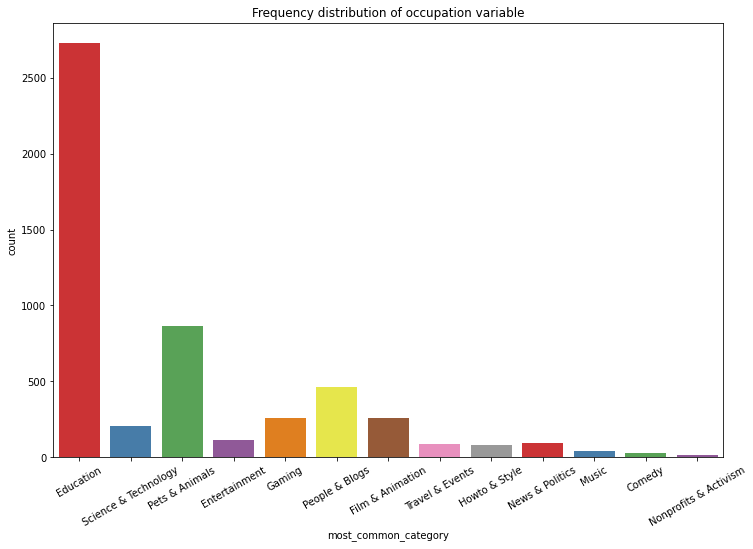

In [36]:
f, ax = plt.subplots(figsize=(12, 8))
ax = sns.countplot(x="most_common_category", data=analysis_df, palette="Set1")
ax.set_title("Frequency distribution of occupation variable")
ax.set_xticklabels(analysis_df.most_common_category.value_counts().index, rotation=30)
plt.show()

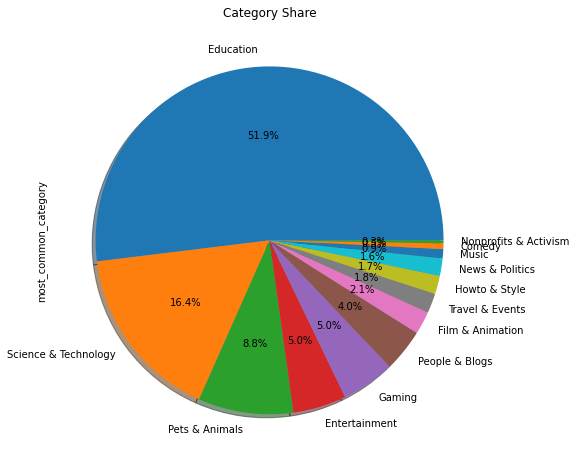

In [37]:
f, ax = plt.subplots(figsize=(12, 8))

ax = analysis_df.most_common_category.value_counts().plot.pie(autopct='%1.1f%%',shadow=True)
ax.set_title('Category Share')
plt.show()

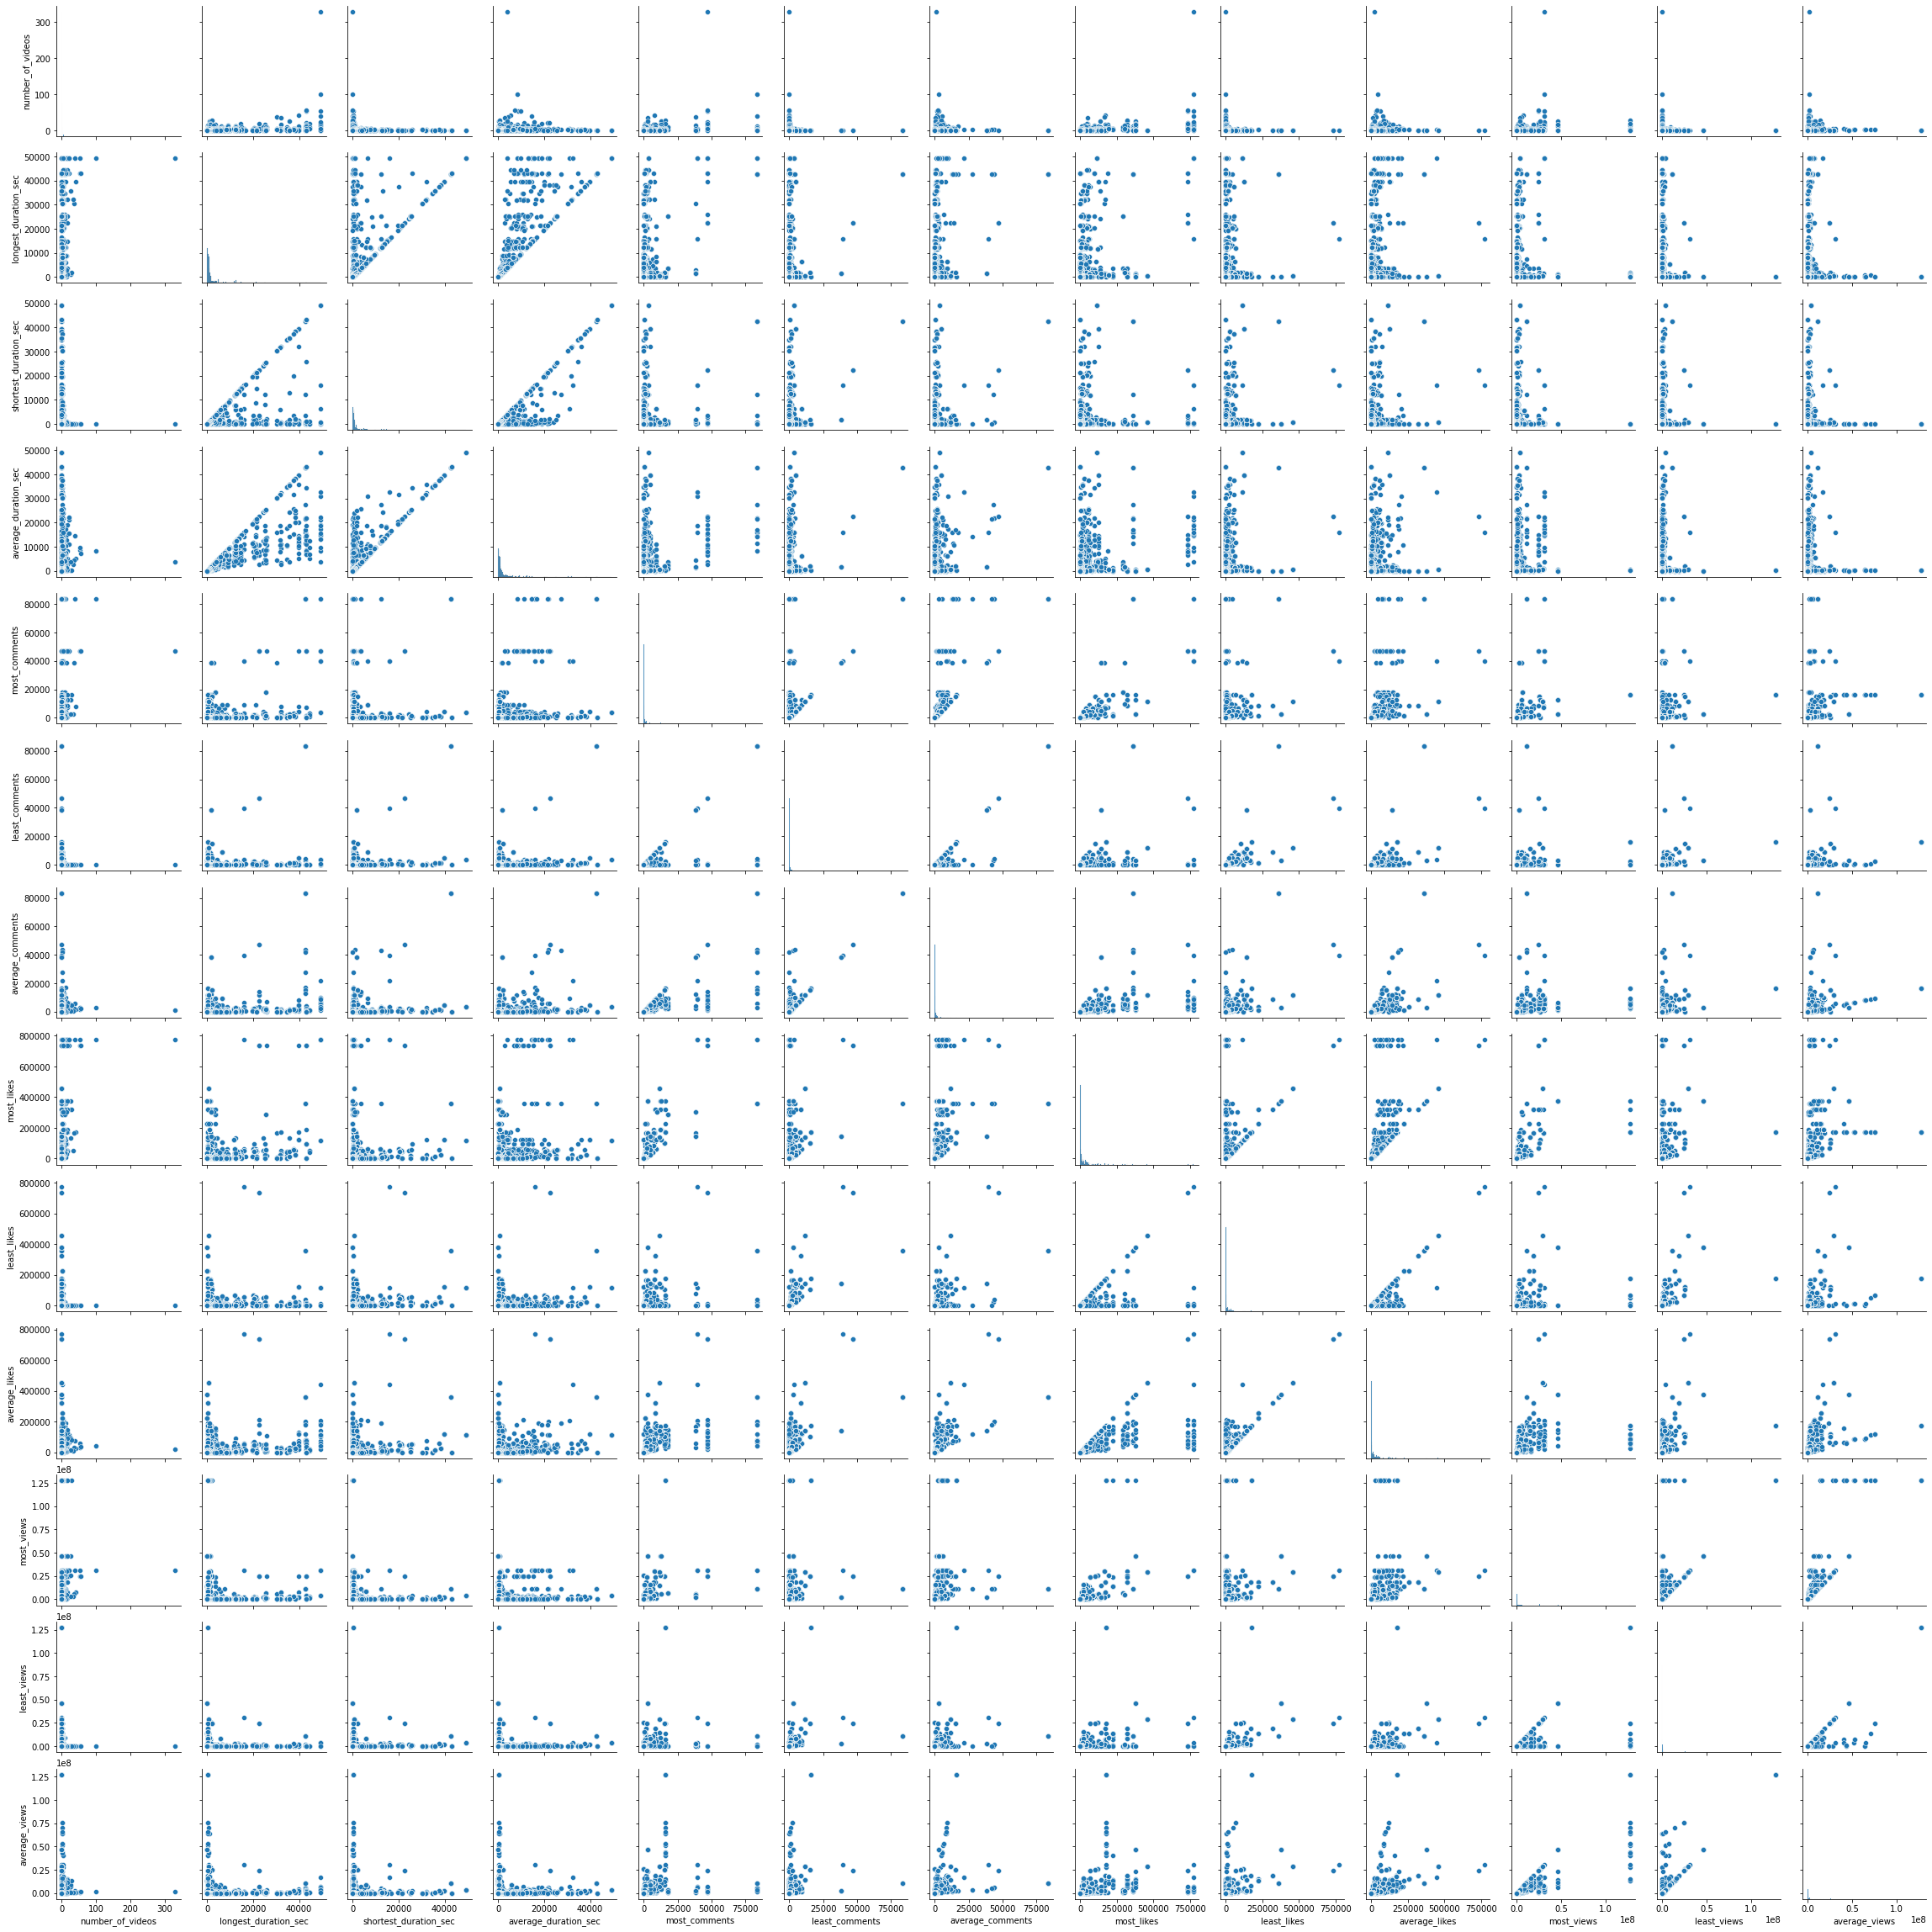

In [38]:
sns.pairplot(analysis_df)
plt.show()

## Feature Engineering & Classification

In [39]:
tag_encoder = preprocessing.LabelEncoder()
cat_encoder = preprocessing.LabelEncoder()

In [40]:
tag_encoder.fit(analysis_df['tag'])
cat_encoder.fit(analysis_df['most_common_category'])

LabelEncoder()

In [41]:
analysis_df['tag'] = tag_encoder.transform(analysis_df['tag'])
analysis_df['most_common_category'] = cat_encoder.transform(analysis_df['most_common_category'])

In [42]:
X = analysis_df.drop(['most_common_category'], axis=1)

y = analysis_df['most_common_category']

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train.shape, X_test.shape

((3674, 14), (1575, 14))

In [47]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [50]:
print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with 100 decision-trees : 0.9663


# Model accuracy score with 100 decision-trees : 96.63%

In [51]:
feature_scores = pd.Series(rfc.feature_importances_, index=X_train.columns).sort_values(ascending=False)

feature_scores

most_views               0.095038
average_views            0.094541
longest_duration_sec     0.085546
least_views              0.085175
average_duration_sec     0.084041
shortest_duration_sec    0.081780
most_likes               0.077871
most_comments            0.074980
least_comments           0.073108
least_likes              0.072528
average_likes            0.071106
average_comments         0.067586
tag                      0.018891
number_of_videos         0.017809
dtype: float64

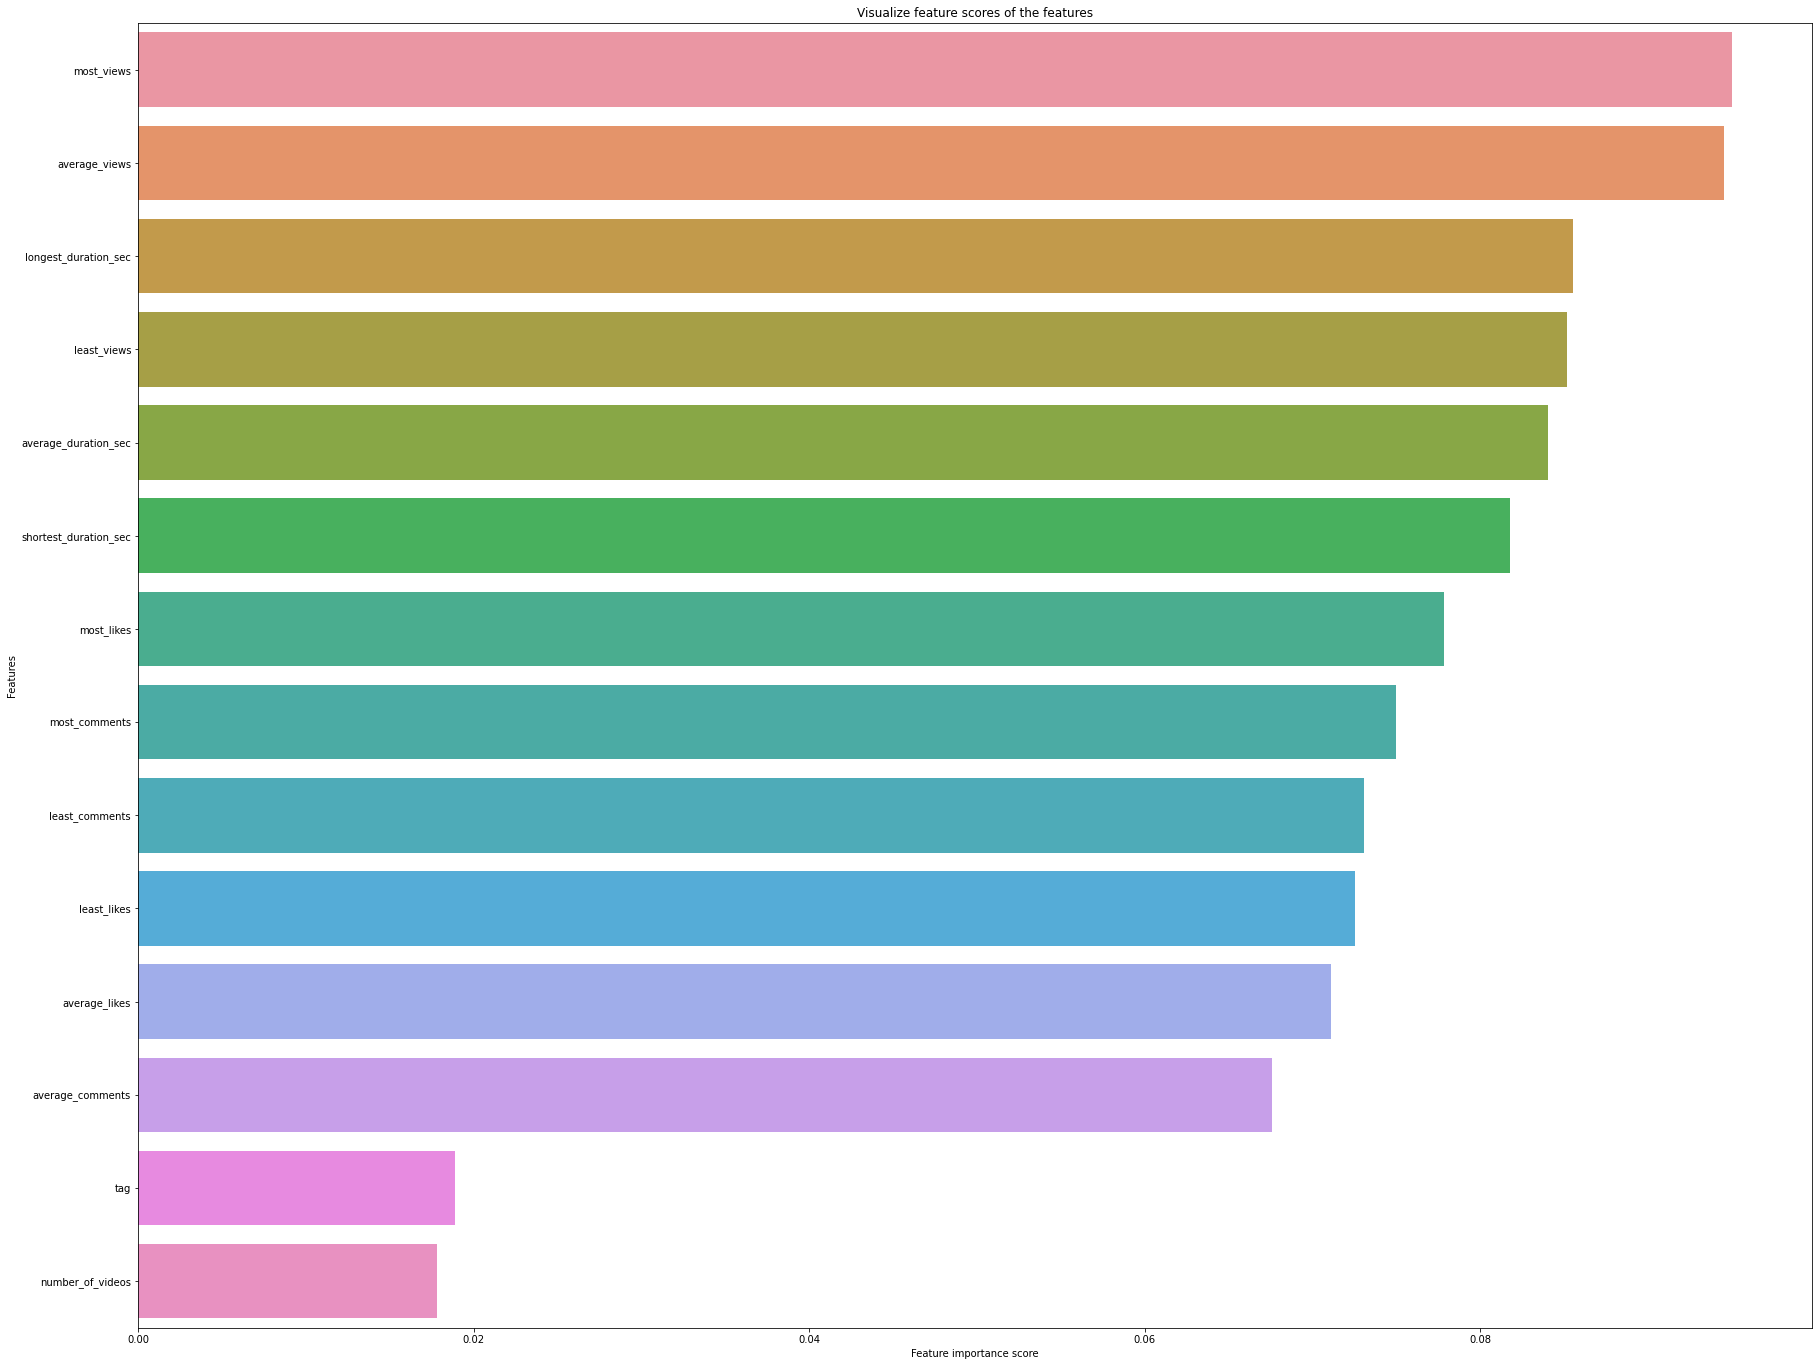

In [52]:
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, data=df)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [53]:
cm = confusion_matrix(y_test, y_pred)

print('Confusion matrix\n\n', cm)

Confusion matrix

 [[  7   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 805   0   0   0   0   0   0   0   0   1   7   0]
 [  0   1  73   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  31   0   0   0   0   0   0   0   0   0]
 [  0   2   0   0  83   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0  26   0   0   0   0   0   0   0]
 [  0   2   0   0   0   0  10   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  32   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   4   0   0   0   0]
 [  0   5   0   0   0   0   0   0   0  48   2   0   0]
 [  1   6   2   0   0   0   0   0   0   0 144   0   0]
 [  0  24   0   0   0   0   0   0   0   0   0 224   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  35]]


<AxesSubplot:>

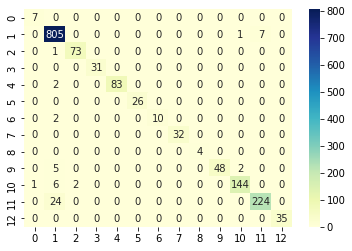

In [54]:
cm_matrix = pd.DataFrame(data=cm)

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       0.95      0.99      0.97       813
           2       0.97      0.99      0.98        74
           3       1.00      1.00      1.00        31
           4       1.00      0.98      0.99        85
           5       1.00      1.00      1.00        26
           6       1.00      0.83      0.91        12
           7       1.00      1.00      1.00        32
           8       1.00      1.00      1.00         4
           9       1.00      0.87      0.93        55
          10       0.98      0.94      0.96       153
          11       0.97      0.90      0.94       248
          12       1.00      1.00      1.00        35

    accuracy                           0.97      1575
   macro avg       0.98      0.96      0.97      1575
weighted avg       0.97      0.97      0.97      1575



# The Basic Requirements along with Bonus is complete



# Possible Improvements

1. Functions can be made to Populate DB with each keyword search, to add new data from json to DB, etc.
2. Reduce the API calls for getting the data of videos that is already stored in DB
3. Updating the Analysis part such that it only gets data of videos associated with the keyword we want to find, for now the whole DB is made for keyword 'python', to make this code scaleable, we will need to associate the search videoID for the keyword with the data already inside the DB, so that when making analysis files, we associate only those videos associated with the search videoID
4. By Implementing 3, we will have a successful ETL pipeline, where we will only need to give KEYWORD, and it will make the analysis report for that KEYWORD, either by gathering new data from API or by using the already stored data in the DB
5. Graphs can be made using excel sheet
6. DB also contains description & title, these can be used for furhter NLP analysis to go more in depth
7. The Classification is biased due to large number of value of one class 'Education'

### Notes
1. The code runs pretty fast as compared to the tasks it runs to achieve the analysis report
2. I verified the accuracy of the data collected along the way, by printing the stats of each tag individually and compared it with search result of youtube 